In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = Path("data/run_table.csv")

OUT_DIR = Path("greentables_figs")  # folder inside your notebook directory
OUT_DIR.mkdir(parents=True, exist_ok=True)

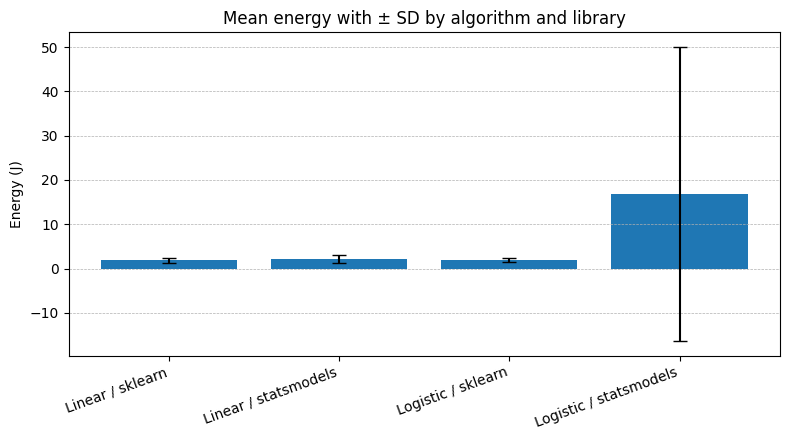

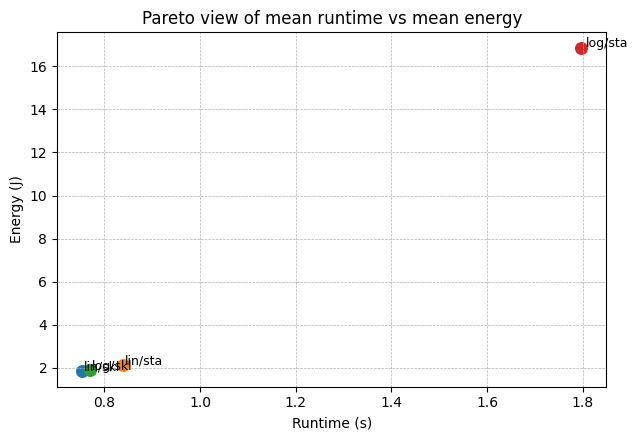

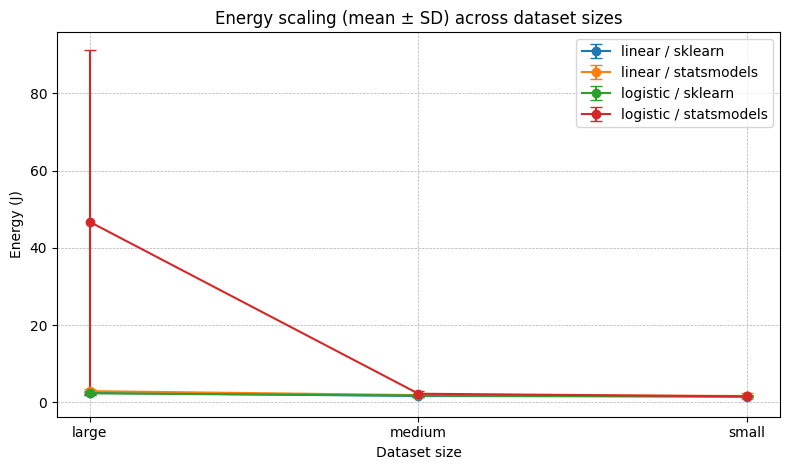

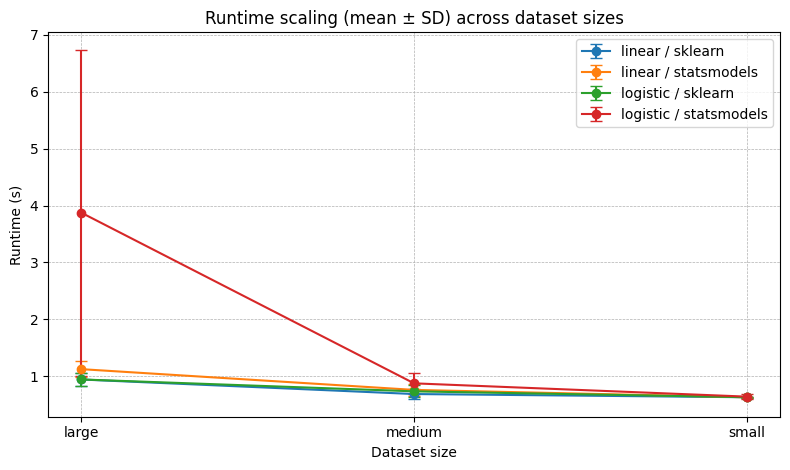

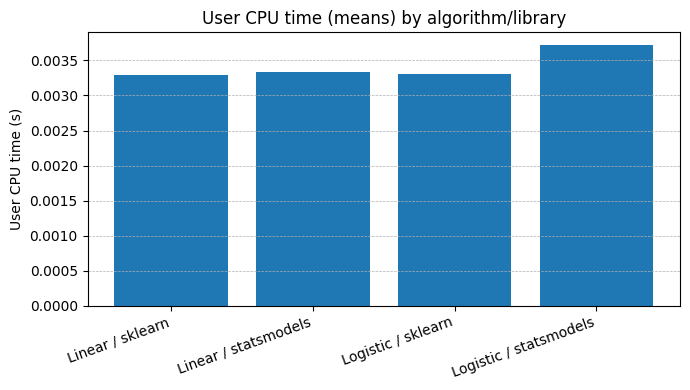

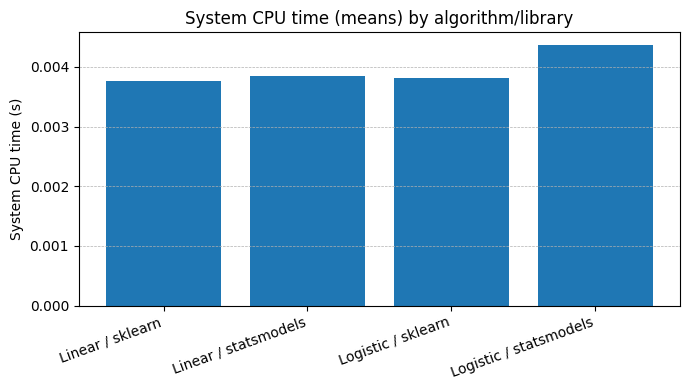

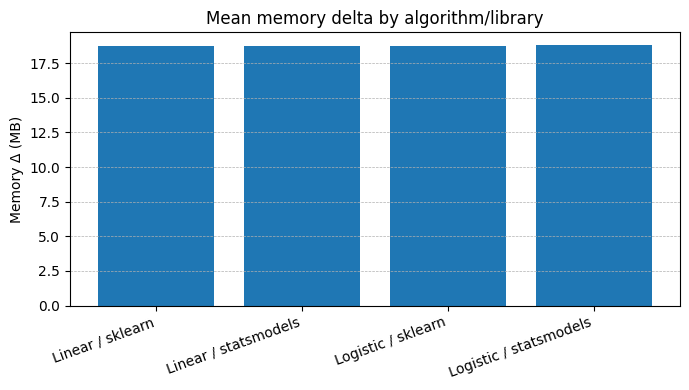

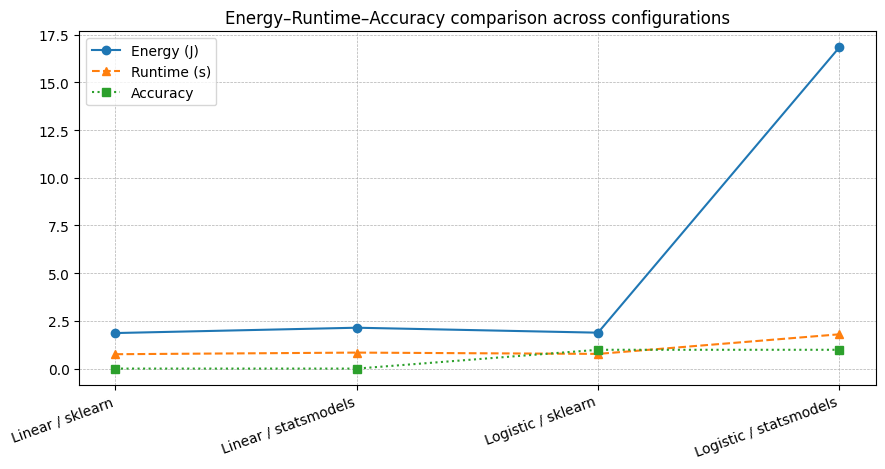


Artifacts saved in: greentables_figs
 - fig_cpu_system_means.png
 - fig_cpu_user_means.png
 - fig_energy_means_sd.png
 - fig_energy_runtime_accuracy.png
 - fig_energy_scaling.png
 - fig_memory_delta.png
 - fig_pareto_runtime_energy.png
 - fig_runtime_scaling.png
 - table_correlations.tex
 - table_relative_efficiency.tex
 - table_rq1_summary.tex
 - table_scaling.tex

Quick summary for manuscript:
corr(runtime, energy) = 0.992
corr(energy, accuracy) = 0.739
corr(runtime, accuracy) = 0.875

Relative deltas (%):
algorithm  delta_energy_pct  delta_runtime_pct
   linear             -13.0              -10.1
 logistic             -88.8              -57.2


In [4]:
# %%
# Jupyter-ready code to reproduce tables and figures for the report
# - Reads your /mnt/data/run_table.csv
# - Computes summary stats, relative deltas, correlations
# - Generates figures: energy means±SD, Pareto (runtime vs energy),
#   energy scaling, runtime scaling, CPU user/sys bars, memory delta bars,
#   energy–runtime–accuracy line plot (1 chart per figure)
# - Exports LaTeX tables to /mnt/data/greentables_figs/*.tex
#
# -----------------------------
# Load data
# -----------------------------
assert DATA_PATH.exists(), f"CSV not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)

# -----------------------------
# Helper: safe correlation
# -----------------------------
def pairwise_corr(a, b):
    s = pd.DataFrame({"a": a, "b": b}).dropna()
    if len(s) < 2:
        return np.nan
    return s.corr().iloc[0, 1]

# -----------------------------
# 1) Summary per algorithm x library
# -----------------------------
summary = (
    df.groupby(["algorithm", "library"])
      .agg(mean_energy_j=("energy_j", "mean"),
           std_energy_j=("energy_j", "std"),
           mean_runtime_s=("runtime_s", "mean"),
           std_runtime_s=("runtime_s", "std"),
           mean_accuracy=("accuracy", "mean"),
           mean_cpu_user=("cpu_user_s", "mean"),
           mean_cpu_sys=("cpu_system_s", "mean"),
           mean_mem_delta=("memory_delta_mb", "mean"))
      .reset_index()
)

summary_rounded = summary.round(3)

# -----------------------------
# 2) Relative efficiency (scikit-learn vs statsmodels) per algorithm
#    Δ% = (sklearn - statsmodels) / statsmodels * 100
# -----------------------------
def rel_delta(alg, metric):
    skl = summary[(summary.algorithm==alg) & (summary.library=="sklearn")][metric].values[0]
    stm = summary[(summary.algorithm==alg) & (summary.library=="statsmodels")][metric].values[0]
    return (skl - stm) / stm * 100.0

rel = pd.DataFrame({
    "algorithm": ["linear","logistic"],
    "delta_energy_pct":[rel_delta("linear","mean_energy_j"), rel_delta("logistic","mean_energy_j")],
    "delta_runtime_pct":[rel_delta("linear","mean_runtime_s"), rel_delta("logistic","mean_runtime_s")]
}).round(1)

# -----------------------------
# 3) Correlations among energy, runtime, accuracy
# -----------------------------
r_energy_runtime = pairwise_corr(df["energy_j"], df["runtime_s"])
acc_df = df[["accuracy","runtime_s","energy_j"]].dropna(subset=["accuracy"])
r_energy_accuracy = pairwise_corr(acc_df["energy_j"], acc_df["accuracy"])
r_runtime_accuracy = pairwise_corr(acc_df["runtime_s"], acc_df["accuracy"])

corrs = pd.DataFrame({
    "": ["Energy","Runtime","Accuracy"],
    "Energy": [1.0, r_energy_runtime, r_energy_accuracy],
    "Runtime": [r_energy_runtime, 1.0, r_runtime_accuracy],
    "Accuracy": [r_energy_accuracy, r_runtime_accuracy, 1.0]
}).round(3)

# -----------------------------
# 4) Scaling per dataset (means ± sd) for energy and runtime
# -----------------------------
scale = (
    df.groupby(["algorithm","library","dataset"])
      .agg(mean_energy_j=("energy_j","mean"),
           sd_energy_j=("energy_j","std"),
           mean_runtime_s=("runtime_s","mean"),
           sd_runtime_s=("runtime_s","std"))
      .reset_index()
      .sort_values(["algorithm","library","dataset"])
)

scale_rounded = scale.round(3)

# -----------------------------
# Output dir for assets
# -----------------------------
OUT_DIR = Path("greentables_figs")  # folder inside your notebook directory
OUT_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------------
# FIGURE A: Mean energy with error bars (by algorithm/library)
# -----------------------------
order = [("linear","sklearn"),
         ("linear","statsmodels"),
         ("logistic","sklearn"),
         ("logistic","statsmodels")]

means = []
errs = []
labels = []
for alg, lib in order:
    row = summary[(summary["algorithm"]==alg) & (summary["library"]==lib)].iloc[0]
    means.append(row["mean_energy_j"])
    errs.append(row["std_energy_j"])
    labels.append(f"{alg.capitalize()} / {lib}")

figA = plt.figure(figsize=(8,4.5))
x = np.arange(len(labels))
plt.bar(x, means, yerr=errs, capsize=5)
plt.xticks(x, labels, rotation=20, ha="right")
plt.ylabel("Energy (J)")
plt.title("Mean energy with ± SD by algorithm and library")
plt.grid(axis="y", linestyle="--", linewidth=0.5)
figA.tight_layout()
figA_path = OUT_DIR / "fig_energy_means_sd.png"
figA.savefig(figA_path, dpi=200)
plt.show()

# -----------------------------
# FIGURE B: Pareto (mean runtime vs mean energy; points = alg/lib means)
# -----------------------------
figB = plt.figure(figsize=(6.5,4.5))
for alg, lib in order:
    row = summary[(summary["algorithm"]==alg) & (summary["library"]==lib)].iloc[0]
    plt.scatter(row["mean_runtime_s"], row["mean_energy_j"], s=70, marker="o")
    plt.text(row["mean_runtime_s"]*1.005, row["mean_energy_j"]*1.005, f"{alg[:3]}/{lib[:3]}", fontsize=9)
plt.xlabel("Runtime (s)")
plt.ylabel("Energy (J)")
plt.title("Pareto view of mean runtime vs mean energy")
plt.grid(True, linestyle="--", linewidth=0.5)
figB.tight_layout()
figB_path = OUT_DIR / "fig_pareto_runtime_energy.png"
figB.savefig(figB_path, dpi=200)
plt.show()

# -----------------------------
# FIGURE C: Energy scaling lines with error bars (per dataset)
# -----------------------------
figC = plt.figure(figsize=(8,4.8))
for (alg, lib), g in scale.groupby(["algorithm","library"]):
    g = g.sort_values("dataset")
    xs = np.arange(len(g))
    plt.errorbar(xs, g["mean_energy_j"], yerr=g["sd_energy_j"], fmt='-o', capsize=4, label=f"{alg} / {lib}")
plt.xticks(range(len(g["dataset"])), g["dataset"])
plt.xlabel("Dataset size")
plt.ylabel("Energy (J)")
plt.title("Energy scaling (mean ± SD) across dataset sizes")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
figC.tight_layout()
figC_path = OUT_DIR / "fig_energy_scaling.png"
figC.savefig(figC_path, dpi=200)
plt.show()

# -----------------------------
# FIGURE D: Runtime scaling lines with error bars (per dataset)
# -----------------------------
figD = plt.figure(figsize=(8,4.8))
for (alg, lib), g in scale.groupby(["algorithm","library"]):
    g = g.sort_values("dataset")
    xs = np.arange(len(g))
    plt.errorbar(xs, g["mean_runtime_s"], yerr=g["sd_runtime_s"], fmt='-o', capsize=4, label=f"{alg} / {lib}")
plt.xticks(range(len(g["dataset"])), g["dataset"])
plt.xlabel("Dataset size")
plt.ylabel("Runtime (s)")
plt.title("Runtime scaling (mean ± SD) across dataset sizes")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
figD.tight_layout()
figD_path = OUT_DIR / "fig_runtime_scaling.png"
figD.savefig(figD_path, dpi=200)
plt.show()

# -----------------------------
# FIGURE E: CPU time means (user + system) by configuration (bars)
# -----------------------------
cpu_labels = labels  # same order as earlier
cpu_user_means = []
cpu_sys_means = []
for alg, lib in order:
    row = summary[(summary["algorithm"]==alg) & (summary["library"]==lib)].iloc[0]
    cpu_user_means.append(row["mean_cpu_user"])
    cpu_sys_means.append(row["mean_cpu_sys"])

# One chart per figure (user, then system)
figE1 = plt.figure(figsize=(7,4))
plt.bar(np.arange(len(cpu_labels)), cpu_user_means)
plt.xticks(np.arange(len(cpu_labels)), cpu_labels, rotation=20, ha="right")
plt.ylabel("User CPU time (s)")
plt.title("User CPU time (means) by algorithm/library")
plt.grid(axis="y", linestyle="--", linewidth=0.5)
figE1.tight_layout()
figE1_path = OUT_DIR / "fig_cpu_user_means.png"
figE1.savefig(figE1_path, dpi=200)
plt.show()

figE2 = plt.figure(figsize=(7,4))
plt.bar(np.arange(len(cpu_labels)), cpu_sys_means)
plt.xticks(np.arange(len(cpu_labels)), cpu_labels, rotation=20, ha="right")
plt.ylabel("System CPU time (s)")
plt.title("System CPU time (means) by algorithm/library")
plt.grid(axis="y", linestyle="--", linewidth=0.5)
figE2.tight_layout()
figE2_path = OUT_DIR / "fig_cpu_system_means.png"
figE2.savefig(figE2_path, dpi=200)
plt.show()

# -----------------------------
# FIGURE F: Memory delta (MB) bar chart
# -----------------------------
mem_means = []
for alg, lib in order:
    row = summary[(summary["algorithm"]==alg) & (summary["library"]==lib)].iloc[0]
    mem_means.append(row["mean_mem_delta"])

figF = plt.figure(figsize=(7,4))
plt.bar(np.arange(len(cpu_labels)), mem_means)
plt.xticks(np.arange(len(cpu_labels)), cpu_labels, rotation=20, ha="right")
plt.ylabel("Memory Δ (MB)")
plt.title("Mean memory delta by algorithm/library")
plt.grid(axis="y", linestyle="--", linewidth=0.5)
figF.tight_layout()
figF_path = OUT_DIR / "fig_memory_delta.png"
figF.savefig(figF_path, dpi=200)
plt.show()

# -----------------------------
# FIGURE G: Energy–Runtime–Accuracy comparison (line plot)
# -----------------------------
# (Accuracy for linear is NaN; show as 0 for plotting just to illustrate.)
acc_plot = []
for alg, lib in order:
    row = summary[(summary["algorithm"]==alg) & (summary["library"]==lib)].iloc[0]
    acc_plot.append(0.0 if pd.isna(row["mean_accuracy"]) else row["mean_accuracy"])

figG = plt.figure(figsize=(9,4.8))
x = np.arange(len(labels))
plt.plot(x, means, marker='o', label="Energy (J)")
rt_means = [summary[(summary["algorithm"]==alg) & (summary["library"]==lib)].iloc[0]["mean_runtime_s"] for alg, lib in order]
plt.plot(x, rt_means, marker='^', linestyle='--', label="Runtime (s)")
plt.plot(x, acc_plot, marker='s', linestyle=':', label="Accuracy")
plt.xticks(x, labels, rotation=20, ha="right")
plt.title("Energy–Runtime–Accuracy comparison across configurations")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
figG.tight_layout()
figG_path = OUT_DIR / "fig_energy_runtime_accuracy.png"
figG.savefig(figG_path, dpi=200)
plt.show()

# -----------------------------
# 5) LaTeX tables
# -----------------------------
TABLE_DIR = OUT_DIR

# RQ1 summary table (mean ± sd + accuracy)
rq1_cols = ["algorithm","library","mean_energy_j","std_energy_j","mean_runtime_s","std_runtime_s","mean_accuracy"]
rq1 = summary_rounded[rq1_cols].copy()
rq1.columns = ["Algorithm","Library","Energy_mean_J","Energy_sd_J","Runtime_mean_s","Runtime_sd_s","Accuracy"]
rq1_tex = rq1.to_latex(index=False, float_format="%.3f")
(TABLE_DIR / "table_rq1_summary.tex").write_text(rq1_tex)

# Relative efficiency (Δ%)
rel_tex = rel.rename(columns={
    "algorithm":"Algorithm",
    "delta_energy_pct":"Delta_energy_pct",
    "delta_runtime_pct":"Delta_runtime_pct"
}).to_latex(index=False, float_format="%.1f")
(TABLE_DIR / "table_relative_efficiency.tex").write_text(rel_tex)

# Correlation matrix
corrs_tex = corrs.to_latex(index=False, float_format="%.3f")
(TABLE_DIR / "table_correlations.tex").write_text(corrs_tex)

# Scaling per dataset (means ± sd)
scale_tex = scale_rounded.rename(columns={
    "algorithm":"Algorithm","library":"Library","dataset":"Dataset",
    "mean_energy_j":"Energy_mean_J","sd_energy_j":"Energy_sd_J",
    "mean_runtime_s":"Runtime_mean_s","sd_runtime_s":"Runtime_sd_s"
}).to_latex(index=False, float_format="%.3f")
(TABLE_DIR / "table_scaling.tex").write_text(scale_tex)

# -----------------------------
# Console summary
# -----------------------------
print("\nArtifacts saved in:", OUT_DIR)
for p in sorted(OUT_DIR.iterdir()):
    print(" -", p.name)

print("\nQuick summary for manuscript:")
print("corr(runtime, energy) =", round(r_energy_runtime, 3))
print("corr(energy, accuracy) =", round(r_energy_accuracy, 3))
print("corr(runtime, accuracy) =", round(r_runtime_accuracy, 3))

print("\nRelative deltas (%):")
print(rel.to_string(index=False))
